In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import string 
import datetime
import gzip

from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pip install scikit-surprise

In [3]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [4]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [5]:
url_review = '/content/drive/My Drive/Data/steam_reviews.json.gz'

In [6]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 15
for l in parse(url_review):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)

In [7]:
url_games = '/content/drive/My Drive/Data/steam_games.json.gz'

In [8]:
data_games = []
for l in parse(url_games):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

https://towardsdatascience.com/steam-recommendation-systems-4358917288eb

# Parte A Exploración de datos

## Reviews

In [9]:
data_reviews.head(4)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
3,S0YxSauCe,0.3,902.0,671270,4,2017-07-10,Easy game. All you have to do is put the hat t...,False,1,NaN,NaN,NaN


In [10]:
data_reviews.shape

(519538, 12)

In [11]:
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
user_id          object
compensation     object
found_funny     float64
dtype: object

In [12]:
#Elimino columnas
data_reviews.drop(['page_order', 'page',
                   'early_access', 'compensation', 'found_funny',
                   'products', 'user_id'],
                   axis=1, inplace=True)

In [13]:
def valores_nulos(data):
  print('<-- Porcentaje de valores nulos -->\n')
  print(data.isnull().sum() / data.shape[0] * 100)

In [14]:
valores_nulos(data_reviews)

<-- Porcentaje de valores nulos -->

username      0.000000
hours         0.338763
product_id    0.000000
date          0.000000
text          0.000000
dtype: float64


In [15]:
print('Un total de {} usuarios realizaron reviews de videojuegos'.format(len(data_reviews.username.unique())))

Un total de 388028 usuarios realizaron reviews de videojuegos


In [16]:
print("<-- Top 10 de Usuarios con mas reviews -->")
data_reviews.username.value_counts().head(10)

<-- Top 10 de Usuarios con mas reviews -->


Alex           135
123            123
Nick           103
Jack           100
Chris           93
Matt            83
Dan             83
Sam             82
Saint Aaron     76
Kodyd194        73
Name: username, dtype: int64

In [17]:
print('<-- Top 10 Videojuegos con mas reviews -->\n ')
top_games = data_reviews.product_id.value_counts().head(10)
i = 0
while i <= 9:
  ids = top_games.index[i]
  ids = data_games[data_games['id'] == ids]
  print('-->', ids.title.iloc[0])
  i = i + 1

<-- Top 10 Videojuegos con mas reviews -->
 
--> Team Fortress 2
--> Rust
--> Borderlands 2
--> Fallout 4
--> Grand Theft Auto V
--> Portal 2
--> Undertale
--> DayZ
--> Warframe
--> Life is Strange - Episode 1


In [18]:
#Convertir a string columnas
columnas = ['username', 'text']
for i in columnas:
  data_reviews[i] = data_reviews[i].astype('string')

#Convertir a int64 columna product_id
data_reviews['product_id'] = data_reviews['product_id'].astype('int64')

In [19]:
#Conversion a tipo datetime64
data_reviews['Fecha'] = pd.to_datetime(data_reviews['date'])
data_reviews['Year'] = data_reviews['Fecha'].dt.year            #Nueva columna con el año del review
data_reviews['month'] = data_reviews['Fecha'].dt.month          #Nueva columna con el mes del review

In [20]:
year_review = data_reviews.groupby(['Year']).count()
year_review

,username,hours,product_id,date,text,Fecha,month
Year,,,,,,,
2010,850,825,850,850,850,850,850
2011,4983,4857,4983,4983,4983,4983,4983
2012,6721,6594,6721,6721,6721,6721,6721
2013,21887,21702,21887,21887,21887,21887,21887
2014,78862,78861,78862,78862,78862,78862,78862
2015,105251,104526,105251,105251,105251,105251,105251
2016,136073,135693,136073,136073,136073,136073,136073
2017,161474,161290,161474,161474,161474,161474,161474
2018,3437,3430,3437,3437,3437,3437,3437


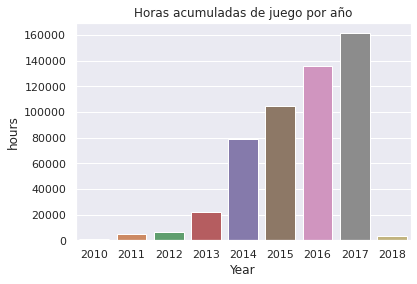

In [21]:
plt.title('Horas acumuladas de juego por año')
sns.barplot(x = year_review.index,
            y=year_review.hours)

In [22]:
months_2017 = data_reviews[data_reviews['Year'] == 2017].groupby(['month']).count()

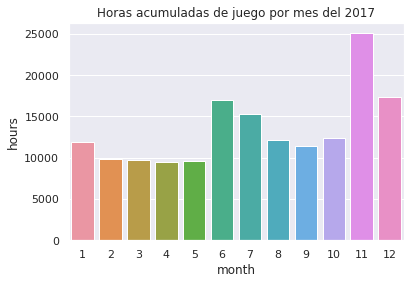

In [23]:
plt.title('Horas acumuladas de juego por mes del 2017')
sns.barplot(x= months_2017.index,
            y=months_2017.hours)

 ## Info Games

In [24]:
data_games.shape

(32135, 16)

In [25]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [26]:
data_games.drop(['reviews_url', 'url', 
                 'early_access', 'discount_price', 
                 'app_name', 'release_date',
                 'discount_price', 'specs', 
                 'sentiment', 'metascore'],
                axis=1,
                inplace=True)

In [27]:
data_games.head(2)

,publisher,genres,title,tags,price,id,developer
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140,Kotoshiro
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,643980,Secret Level SRL


In [28]:
data_games.shape

(32135, 7)

In [29]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

publisher    25.056792
genres       10.216275
title         6.379337
tags          0.507235
price         4.285047
id            0.006224
developer    10.266065
dtype: float64


In [30]:
print('<-- Desarrolladores con mas videojuegos registrados -->\n')
data_games.developer.value_counts().head(10)

<-- Desarrolladores con mas videojuegos registrados -->



Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Stainless Games                 95
Musopia                         95
Name: developer, dtype: int64

Text(0, 0.5, 'Frecuencia')

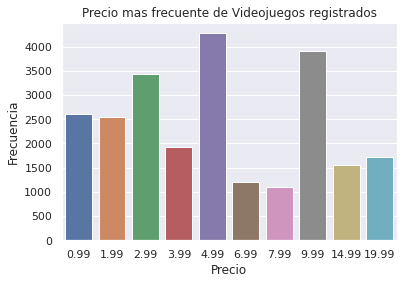

In [31]:
price_games = data_games.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente de Videojuegos registrados')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# EDA

In [33]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

publisher    25.056792
genres       10.216275
title         6.379337
tags          0.507235
price         4.285047
id            0.006224
developer    10.266065
dtype: float64


In [34]:
#Elimino valore nulos en data_games
data_games.dropna(subset=['tags', 'id', 'title'], axis=0, inplace=True)

In [35]:
#Convertir a string
data_games['genres'] = data_games['genres'].astype('string')
data_games['tags'] = data_games['tags'].astype('string')

In [36]:
#Convertir a int
data_reviews['product_id'] = data_reviews['product_id'].astype(int)
data_games['id'] = data_games['id'].astype(int)

In [37]:
#Submuestra
df_games = data_games.sample(frac=0.04)
df_games.reset_index(drop=True, inplace=True)

df_reviews = data_reviews.sample(frac=0.04)
df_reviews.reset_index(drop=True, inplace=True)

In [38]:
 #df_games['tags'] = df_games['tags'].fillna(' ')
 df_games['xtags'] = df_games['tags'].str.replace('[{}]'.format(string.punctuation), ' ')

In [39]:
df_games.head(2)

,publisher,genres,title,tags,price,id,developer,xtags
0,Chilled Mouse,"['Adventure', 'Indie', 'RPG']",Torn Tales,"['Adventure', 'RPG', 'Indie']",12.99,388960,Twistplay,Adventure RPG Indie
1,Solo Instinct,"['Casual', 'Indie', 'Simulation', 'Early Access']",Production Inc.,"['Early Access', 'Indie', 'Casual', 'Simulation']",19.99,378390,Solo Instinct,Early Access Indie Casual Simulation


In [ ]:
break

# Recomendaciones

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')        #Defino las stopwords
tfidf = TfidfVectorizer(stop_words=set(stopwords))        #Defino el modelo
tfidf_matrix = tfidf.fit_transform(df_games['xtags'])   #Creo matriz

In [ ]:
'''
Matriz de comparación
Compara las etiquetas de un video seleccionado con la lista anterior
en busca de palabras similares
'''
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
print(len(tfidf.vocabulary_))
print(tfidf_matrix.shape)

335
(1197, 335)


In [ ]:
indices = pd.Series(df_games.index, index=df_games['title']).drop_duplicates()

In [ ]:
def get_recomendation(title, cosine_sim=cosine_sim):
    idx = indices[title]                                                        #Selecciona el titulo del videojuego                        
    sim_scores = list(enumerate(cosine_sim[idx]))                               
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)           #Ordena de mayor a menor las similitudes
    sim_scores = sim_scores[1:6]                                                #Selecciona las primero 5 similitudes
    games_indices = [i[0] for i in sim_scores]
    return df_games['title'].iloc[games_indices]                                #Retorna el nombre de los videojuegos

In [ ]:
def recomendation():
  '''
  Se seleccionara un id de un videojuego al azar, simulando que el usuario ya selecciono
  el videojuego que va jugar y escribir su reseña'''
  ids  = np.random.randint(df_games.shape[0])                         #Obtiene una linea al azar
  ids  = df_games.id.iloc[ids]                                        #Obtiene el id del videojuego seleccionado al azar
  name = (df_games.loc[df_games['id'] == ids]['title']).iloc[0]       #Busca el nombre del id del videojuego 
  print('Usted ha jugado: {}'.format(name))
  input('Ingrese su reseña: ')
  print('\nNuestras recomendaciones:')
  print(get_recomendation(name))

In [ ]:
recomendation()

Usted ha jugado: TankZone Battle
Ingrese su reseña: excelente

Nuestras recomendaciones:
612                           PlanetSide 2
39           Military Life: Tank Simulator
1112       Tom Clancy's Rainbow Six® Vegas
466     White Noise 2 - Corey &amp; Shaira
240                         Sniper Elite 3
Name: title, dtype: object


# Procesamiento de lenguaje natural

In [42]:
df_reviews.drop(['hours', 'date', 'Fecha', 'Year', 'month'], axis=1, inplace=True)

In [43]:
valores_nulos(df_reviews)

<-- Porcentaje de valores nulos -->

username      0.0
product_id    0.0
text          0.0
dtype: float64


## Emojis

In [ ]:
pip install emoji

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=030a4a3dfbabc610e5b97bb996702e4fb7a99a8eb0b16ff441af986600cc6fff
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
#Elimino cualquier emoji presente en la review escrita
import emoji

In [ ]:
df_reviews.tail(2)

,username,product_id,text,user_id
20780,LuciLoli,257850,Zelda-Darks souls baby.,76561198106971121
20781,Machiav,208400,Nostalgy for past... wonderfull memories from ...,76561198019180347


In [ ]:
#df_reviews['xtext'] = emoji.demojize(df_reviews['text'])

## Traduccion de comentario

In [ ]:
#df_reviews['xtext'] = df_reviews['text'].apply(lambda x: TextBlob(x).translate(to='en'))

In [ ]:
#Ya que todos los comentarios se encuentran en ingles, la celda anterior marca error, ya que no tiene acciones por realizar

## Estandarizar el texto

In [46]:
 #Elimino signos
 df_reviews['xtext'] = df_reviews['text'].str.replace('[{}]'.format(string.punctuation), ' ')

In [47]:
#Texto estandarizado
comentario = df_reviews.xtext.iloc[1]
comentario

'This game is pretty funny and it s free if you get it from the Zombie Cow website '

## Polaridad y subjetividad de reviews

In [ ]:
#Correcion de escritura
#correciones = []

#for i in range(df_reviews.shape[0]):
#  correcion = df_reviews.xtext.iloc[i]
#  correcion = TextBlob(correcion).correct()
#  correciones.append(correcion)

#df_reviews['xtext'] = correciones

In [ ]:
#TextBlob(comentario).sentimen

Sentiment(polarity=0.07666666666666666, subjectivity=0.5066666666666667)

In [48]:
#Creacion de una nueva columna con la polaridad de la review
comentarios = []

for i in range(df_reviews.shape[0]):
  comentario = df_reviews.xtext.iloc[i]
  comentario = TextBlob(comentario).polarity
  comentarios.append(comentario)

df_reviews['polariy'] = comentarios

In [49]:
#Creacion de una nueva columna con la subjetividad de la revoew
comentarios = []

for i in range(df_reviews.shape[0]):
  comentario = df_reviews.xtext.iloc[i]
  comentario = TextBlob(comentario).subjectivity
  comentarios.append(comentario)

df_reviews['subjectivity'] = comentarios

In [50]:
df_reviews.head(2)

,username,product_id,text,xtext,polariy,subjectivity
0,SyphonxZA,578330,Cons: - Random slowdowns now and then - Very f...,Cons Random slowdowns now and then Very f...,-0.212083,0.616250
1,tenshi_a,37400,This game is pretty funny and it's free if you...,This game is pretty funny and it s free if you...,0.073333,0.673333


In [51]:
#Creo una copia de las review, que mas adelante empleare
calificaciones = df_reviews[['username', 'product_id', 'polariy']]

# Machine Learning
## Modelo Prediccion

In [55]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [56]:
#Defino el modelo reader
reader = Reader()

#Creo Dataset para el modelo
N_filas = 2000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(calificaciones[['username', 'product_id', 'polariy']][:N_filas], reader)

In [58]:
#Division de Datos de entrenamiento y test
trainset, testset = train_test_split(data, test_size=.25)

In [59]:
from surprise import SVD
algo = SVD()
#Entreno modelo
algo.fit(trainset)

In [61]:
#Realizo predicciones
predictions = algo.test(testset)

In [63]:
#Selecciono el usuario con mas reviews
calificaciones[calificaciones['username'] == '123']

,username,product_id,polariy
6402,123,337000,-0.075000
12005,123,346110,-0.007305
14038,123,383120,0.265000
14279,123,287920,-0.089272
15813,123,99900,0.225000


In [73]:
usuario = '123'  
polariy = -1.0
df_user = df_reviews[(df_reviews['username'] == usuario) & (df_reviews['polariy'] >= polariy)]
df_user.reset_index(drop=True, inplace=True)
names = []
for i in df_user.product_id:
  name = data_games[data_games['id'] == i]
  name = name.title.values[0]
  names.append(name)


df_user['game_name'] = names

In [74]:
df_user

,username,product_id,text,xtext,polariy,subjectivity,game_name
0,123,337000,Game is garbage! Dont Buy it you will just be ...,Game is garbage Dont Buy it you will just be ...,-0.075000,0.325000,Deus Ex: Mankind Divided
1,123,346110,The new update is horrible. The menus look lik...,The new update is horrible The menus look lik...,-0.007305,0.561364,ARK: Survival Evolved
2,123,383120,i really liked the idea at first but after try...,i really liked the idea at first but after try...,0.265000,0.728333,Empyrion - Galactic Survival
3,123,287920,"Played mortal on and off since 2013, lots of b...",Played mortal on and off since 2013 lots of b...,-0.089272,0.467507,Mortal Online
4,123,99900,The art direction in this game is beautiful! a...,The art direction in this game is beautiful a...,0.225000,0.700000,Spiral Knights


In [85]:
#Creo una copia del Dataser donde se encuentran todos los juegos registrados
recomendaciones_games = data_games.iloc[0:]

In [106]:
#Juegos que el usuario ya jugo"
juegos_jugados = data_reviews[data_reviews['username'] == usuario]
#Elimino los juegos que tienen mas de 1 review para el mismo usuario, conservando la ultima review
juegos_jugados.drop_duplicates(subset='product_id',keep='first', inplace=True)
print('El usuario ya ha jugado',juegos_jugados.shape[0],'videojuegos\n')
juegos_jugados.head(3)

El usuario ya ha jugado 74 videojuegos



,username,hours,product_id,date,text,Fecha,Year,month
9058,123,69.3,271590,2017-09-15,Nice game ever,2017-09-15,2017,9
11616,123,26.7,337000,2016-10-07,Game is garbage! Dont Buy it you will just be ...,2016-10-07,2016,10
25352,123,195.9,445220,2017-04-24,"Ok, i never do reviews but at first im gonna s...",2017-04-24,2017,4


In [86]:
#Elimino los juegos que el usuario ya ha jugado
for i in juegos_jugados.product_id:
  id = i
  recomendaciones_games.drop(recomendaciones_games[recomendaciones_games['id'] == id ].index, inplace=True)

In [107]:
recomendaciones_games.head(2)

,publisher,genres,title,tags,price,id,developer,Score_estimate
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.99,761140,Kotoshiro,1
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",Free To Play,643980,Secret Level SRL,1


In [93]:
usuario

'123'

In [94]:
#Realizo predicciones sobre de posible positividads
recomendaciones_games['Score_estimate'] = recomendaciones_games['id'].apply(lambda x:algo.predict(usuario, x).est)

In [100]:
recomendaciones_games.Score_estimate.max()

1

In [101]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.9546


0.9546477716185167

In [102]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9442  0.9413  0.9365  0.9407  0.0032  
Fit time          0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9353  0.9429  0.9438  0.9407  0.0038  
Fit time          0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9409  0.9437  0.9374  0.9407  0.0025  
Fit time          0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

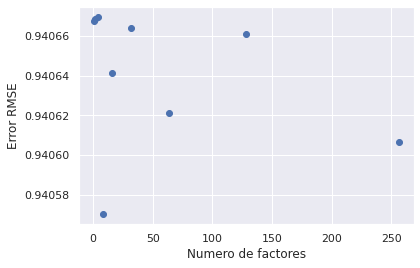

In [103]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [104]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [105]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9406714717254901
{'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.002}


In [ ]:
import nltk
import goslate
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
data_reviews.head(2)

In [ ]:
valores_nulos(data_reviews)


https://www.youtube.com/watch?v=oy1lcj8s8sQ&t=620s  -->PRocesamiento de comentario

https://stackoverflow.com/questions/57744725/how-to-convert-emojis-emoticons-to-their-meanings-in-python --> Convertir emojis to text


In [ ]:
#Defino el modelo para traduccion
gs = goslate.Goslate()

In [ ]:
  s = data_reviews.text.iloc[2]

In [ ]:
TextBlob(s).translate(to = 'en')

In [ ]:
for i in range(data_reviews.shape[0]):
  reviews = data_reviews.text.iloc[i]
  data_reviews['Traduccion'] = gs.translate(reviews,'en')

In [ ]:
pip install goslate

In [ ]:
import goslate

In [ ]:
text = "Hello World"

gs = goslate.Goslate()
translatedText = gs.translate(text,'es')

In [ ]:
print(translatedText)

In [ ]:
for i in range(data_reviews.shape[0]):
  reviews = data_reviews.text.iloc[i]
  data_reviews['Traduccion'] = TextBlob(reviews).detect_language()

In [ ]:
import emoji

In [ ]:
corazon = '😁'

In [ ]:
print(emoji.demojize(corazon))

:beaming_face_with_smiling_eyes:


In [ ]:
a = data_reviews.text.iloc[6]

In [ ]:
a

'Putting a hat on your head has disasterous repercussions.'

In [ ]:
print(emoji.demojize(a))

Putting a hat on your head has disasterous repercussions.
